## 사용자 불만 접수 원인 분석

In [119]:
import pandas as pd
import numpy as np
import matplotlib
font = {'size': 16, 'family':"NanumGothic"}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

data_path = 'data/'
N_ERRTYPE = 42

### 1. Error 데이터

### 학습데이터 로드 및 전처리

In [107]:
train_err = pd.read_csv(data_path + 'train_err_data.csv')
train_err.drop_duplicates(inplace=True)
train_err = train_err.reset_index(drop=True)
train_err['time'] = pd.to_datetime(train_err['time'], format='%Y%m%d%H%M%S')
train_prob = pd.read_csv(data_path + 'train_problem_data.csv')
train_prob['time'] = pd.to_datetime(train_prob['time'], format='%Y%m%d%H%M%S')
train_prob['time_day'] = train_prob['time'].dt.day
train_prob['time_hour'] = train_prob['time'].dt.hour
# del train_prob['time']

problem_arr = np.zeros((15000, 30), dtype=int)
for i in range(train_prob.shape[0]):
    user_id = train_prob.loc[i,'user_id']
    time_day = train_prob.loc[i, 'time_day']
    problem_arr[user_id - 10000, time_day-1] += 1

### 데이터 transformation: Error data를 일별로 count

In [2]:
from main import *

# error code encoder load
encoder = get_encoder()
errcode_names = encoder.classes_

# 유저별로 processing하고 concatenate
err_df_in_day_user = split_error_data_in_day(train_err_df, 'train')
data_list = []
for user_idx in range(15000):
    data_list.append(err_df_in_day_user[user_idx])

err_list = []
for data in tqdm(data_list):
    err_list.append(transform_errtype(data))
err_arr = np.array(err_list)

err_df = extract_err(err_arr, WINDOW=1)

# 각각이 어떤 feature인지
data_cols = []
for i in range(N_NEW_ERRCODE):
    data_cols.append('errorcode_' + errcode_names[i])
for i in range(N_ERRTYPE):
    data_cols.append('errortype_'+ str(i+1))
data_cols.append('errortype_38_code_summation')

# 제외하고 분석할 error code 제외
drop_codes = ['errorcode_'+ str(c) + '-' for c in [10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 35, 36, 41]]

remaining_idx = []
for i in range(err_arr.shape[2]):
    flag = True
    for drop_code in drop_codes:
        if drop_code in data_cols[i]:
            flag = False
            break
    if flag:
        remaining_idx.append(i)

err_arr = err_arr[:,:,remaining_idx]
data_cols = np.array(data_cols)[remaining_idx]

N_FEATURES = len(data_cols)

feature = []
for i in range(err_df.shape[1]):
    remain = True
    col = err_df.columns[i]
    for code in drop_codes:
        if code in col:
            remain = False
            break
    if remain:
        feature.append(err_df[col])
feature = pd.concat(feature, axis=1)

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 12435/15000 [04:08<00:44, 57.50it/s]

UNKNOWN error code for type 5 :: http


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:01<00:00, 49.79it/s]


### 에러 발생량과 사용자 불만 여부와 상관관계

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


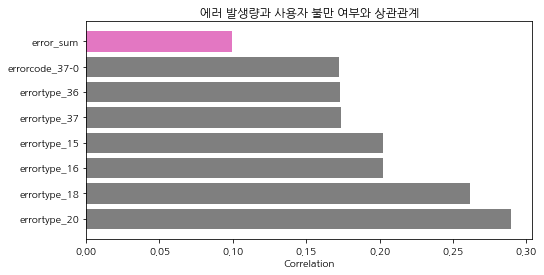

In [10]:
corr_result = []
# 전체 error code와 type 개별적으로
for err_idx in range(N_FEATURES):
    err_arr_sub = err_arr[:,:,err_idx]
    corr_result.append(np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=1))[0,1])
corr_result = np.array(corr_result)

# nan 제거
nan_idx = np.isnan(corr_result)
corr_result = corr_result[~nan_idx]
columns = np.array(data_cols)
columns = columns[~nan_idx]

# 높은 순서대로 sorting
idx = np.argsort(corr_result)[::-1]
corr_result = corr_result[idx]
columns = columns[idx]

NUM_SHOW = 7
corr_result = corr_result[:NUM_SHOW]
columns = columns[:NUM_SHOW]

# plot
plt.figure(figsize=(8,4))
plt.barh(range(NUM_SHOW), corr_result, color='tab:gray')

# 전체 error type의 sum
err_arr_sub = err_arr[:,:,-N_ERRTYPE-1:-1]
sum_corr = np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=2).sum(axis=1))[0,1]

plt.barh([NUM_SHOW], [sum_corr], color='tab:pink')
plt.yticks(range(NUM_SHOW+1), np.append(columns, 'error_sum'))
plt.xlabel('Correlation')
plt.title('에러 발생량과 사용자 불만 여부와 상관관계')
plt.show()

### 불만 제기 여부에 따른 하루 평균 에러 발생량

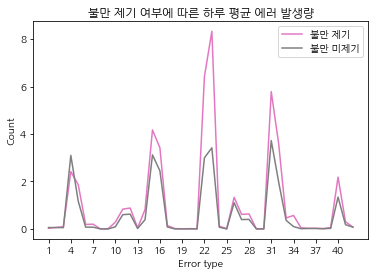

In [11]:
import seaborn as sns

# 에러 타입의 전체 합계
err_arr_sub = err_arr[:,:,-N_ERRTYPE-1:-1]

# 문제가 발생한 유저와 발생하지 않은 유저로 분리
problem_user = (problem_arr.sum(axis=1) > 0)
problem_0_err = err_arr_sub[problem_user,:,:]
problem_1_err = err_arr_sub[~problem_user,:,:]

# 유저당 일별 평균값 산출
problem_0_err = problem_0_err.mean(axis=0).mean(axis=0)
problem_1_err = problem_1_err.mean(axis=0).mean(axis=0)

plt.figure(figsize=(6,4))
plt.plot(problem_0_err, label='불만 제기', color='tab:pink')
plt.plot(problem_1_err, label='불만 미제기', color='tab:gray')
plt.xlabel('Error type')
plt.ylabel('Count')
plt.title('불만 제기 여부에 따른 하루 평균 에러 발생량')
plt.xticks(range(42)[::3], range(1,43)[::3])
plt.legend()
plt.show()

### 모델별 불만 발생량

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:34<00:00, 440.42it/s]


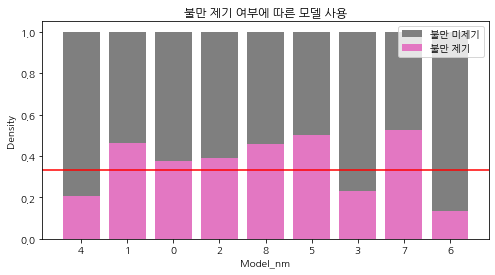

In [12]:
# model 관련 피쳐 생성
model_list = []
for data in tqdm(data_list):
    model_list.append(transform_model_nm(data))
model_arr = np.array(model_list)
model_df = extract_model_nm(model_arr, range(10000,25000))

density = []
for i in range(9):
    model_idx = (model_df['model_'+str(i)] == 1).values
    problem_user_model = problem_user[model_idx]
    density.append(problem_user_model.mean())
density = np.array(density)

plt.figure(figsize=(8,4))
model_sort_order =  np.array([4, 1, 0, 2, 8, 5, 3, 7, 6])
plt.bar(range(9), [1] * 9, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(9), density[model_sort_order], color='tab:pink', label='불만 제기')
plt.xticks(range(9), model_sort_order)
plt.xlabel('Model_nm')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 모델 사용')
plt.show()


### 펌웨어별 불만 발생

  0%|▉                                                                                                                                                                                           | 71/15000 [00:00<00:23, 638.63it/s]

Extract features from fwver...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:24<00:00, 622.52it/s]


Extract features from fwver is done


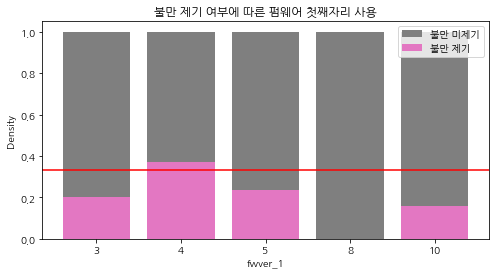

In [13]:
print('Extract features from fwver...')
fwver_list = []
for data in tqdm(data_list):
    fwver_list.append(transform_fwver(data))
fwver_arr = np.array(fwver_list)
id_list = range(10000, 25000)
fwver_arr = fwver_arr.astype(int)
fwver_diff = np.zeros((len(id_list), 3), dtype=int)
fwver_start = np.zeros((len(id_list), 3), dtype=int)
fwver_end = np.zeros((len(id_list), 3), dtype=int)
fwver_upgrade = np.zeros((len(id_list), 3), dtype=int)
fwver_downgrade = np.zeros((len(id_list), 3), dtype=int)

# 각 user마다
for i in range(len(id_list)):
    for j in range(3):
        data_sub = fwver_arr[i][:, j]
        data_sub = data_sub[data_sub != 0]

        # fwver diff
        fwver_diff[i, j] = np.max([len(np.unique(data_sub)) - 1, 0])
        occur_idx = np.where(data_sub)[0]
        if occur_idx.size == 0:
            continue

        # fwver start
        first_occur_idx = occur_idx[0]
        fwver_class_start = data_sub[first_occur_idx]
        fwver_start[i, j] = fwver_class_start

        # fwver end
        last_occur_idx = occur_idx[-1]
        fwver_class_end = data_sub[last_occur_idx]
        fwver_end[i, j] = fwver_class_end

        # fwver upgrade or downgrade
        fwver_upgrade[i, j] = fwver_class_start < fwver_class_end
        fwver_downgrade[i, j] = (fwver_class_start > fwver_class_end) * -1

fwver_df = pd.DataFrame()
for j in range(3):
    fwver_df['fwver_diff_' + str(j)] = fwver_diff[:, j]
    fwver_df['fwver_start_' + str(j)] = pd.Series(fwver_start[:, j])
    fwver_df['fwver_end_' + str(j)] = pd.Series(fwver_end[:, j])
    fwver_df['fwver_upgrade_' + str(j)] = pd.Series(fwver_upgrade[:, j])
    fwver_df['fwver_downgrade_' + str(j)] = pd.Series(fwver_downgrade[:, j])
fwver_df['fwver_start'] = fwver_df['fwver_start_0'].astype(str)+'.' + fwver_df['fwver_start_1'].astype(str)+'.' + fwver_df['fwver_start_2'].astype(str)
fwver_df['fwver_end'] = fwver_df['fwver_end_0'].astype(str)+'.' + fwver_df['fwver_end_1'].astype(str)+'.' + fwver_df['fwver_end_2'].astype(str)

print('Extract features from fwver is done')

unique_fwver_1 = np.unique(fwver_df['fwver_start_0'])
density = []
for fwver in unique_fwver_1:
    fwver_idx = (fwver_df['fwver_start_0'] == fwver).values
    problem_user_fwver = problem_user[fwver_idx]
    density.append(problem_user_fwver.mean())
density = np.array(density)

N_FWVER_1 = len(unique_fwver_1)
plt.figure(figsize=(8,4))
plt.bar(range(N_FWVER_1), [1] * N_FWVER_1, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(N_FWVER_1), density, color='tab:pink', label='불만 제기')
plt.xticks(range(N_FWVER_1), unique_fwver_1)
plt.xlabel('fwver_1')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 펌웨어 첫째자리 사용')
plt.show()

### 모델이나 펌웨어 변경 여부에 따른 불만 발생률

In [20]:
## 1. 펌웨어 첫째자리 변경 여부
print('===fwver_1===')
print('upgrade')
idx_f_u = fwver_df['fwver_start_0'] < fwver_df['fwver_end_0']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start_0'] > fwver_df['fwver_end_0']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start_0'] != fwver_df['fwver_end_0']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

## 2. 모델 변경 여부
print('===model_nm===')
# upgrade
idx_u = model_df['model_upgrade'] > 0
print('upgrade')
print((problem_user * idx_u.values).sum() / idx_u.sum())

# downgrade
idx_d = model_df['model_downgrade'] < 0
print('downgrade')
print((problem_user * idx_d.values).sum() / idx_d.sum())

# diff
idx_diff = model_df['model_diff'] > 0
print('different')
print((problem_user * idx_diff.values).sum() / idx_diff.sum())

## 3. 펌웨어 변경 여부
print('===fwver===')
print('upgrade')
idx_f_u = fwver_df['fwver_start'] < fwver_df['fwver_end']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start'] > fwver_df['fwver_end']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start'] != fwver_df['fwver_end']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

===fwver_1===
upgrade
0.8
downgrade
0.6823529411764706
different
0.6888888888888889
===model_nm===
upgrade
0.9532554257095158
downgrade
0.6777777777777778
different
0.914651493598862
===fwver===
upgrade
0.3911849169684105
downgrade
0.6666666666666666
different
0.39434707479634656


Text(0, 0.5, 'user index')

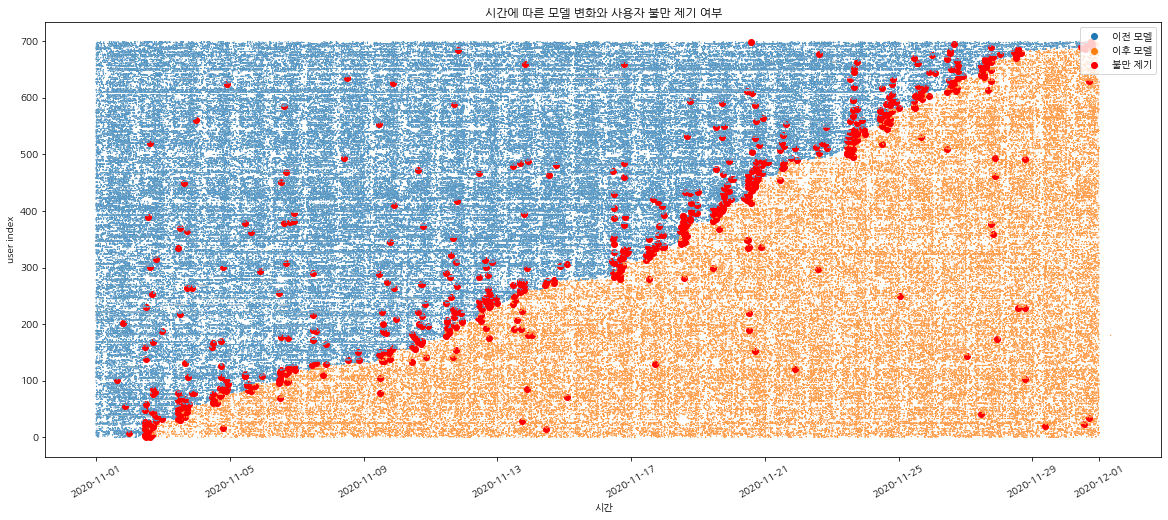

In [118]:
v=train_err[['user_id','model_nm']]
getdf =~(v == v.shift(1))
logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
tre_model_counts=v[logical]

user_id_2_model = tre_model_counts.user_id.value_counts()
user_id_lst_2_model=list(user_id_2_model.loc[user_id_2_model ==2].to_frame().index)
sort_two_model_user = train_err.loc[train_err.user_id.isin(user_id_lst_2_model)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id

plt.figure(figsize=(20,8))
for i,value in enumerate(sort_two_model_user):
    smt = train_err.loc[train_err.user_id ==value]
    p_time = train_prob.loc[train_prob.user_id ==value].time.values
    sns.scatterplot(data=smt,x='time',y=np.ones(len(smt))*i,hue='model_nm',s=1)
    plt.scatter(p_time,np.ones(len(p_time))*i,c='r',label='problem occur')
 
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgnd=plt.legend(list(by_label.values())[:3], ['이전 모델','이후 모델','불만 제기'],loc='upper right')

plt.title("시간에 따른 모델 변화와 사용자 불만 제기 여부")
plt.xticks(rotation = 30)
plt.xlabel("시간")
plt.ylabel("user index")